In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [2]:
generating_df = pd.read_csv('monte_carlo_10000.csv').drop(columns=['sample'])
training_df = pd.read_csv('training_data.csv')

In [3]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[['mean_force']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
generating_array = generating_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
generating_array_scaled = scaler.transform(generating_array)
X_val = scaler.transform(X_val)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0022519
      Initializing linear solver - done. Time (sec):  0.0023012
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0005097
      Solving linear system (col. 0) - done. Time (sec):  0.0005240
   Training - done. Time (sec):  0.0048940
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Pre

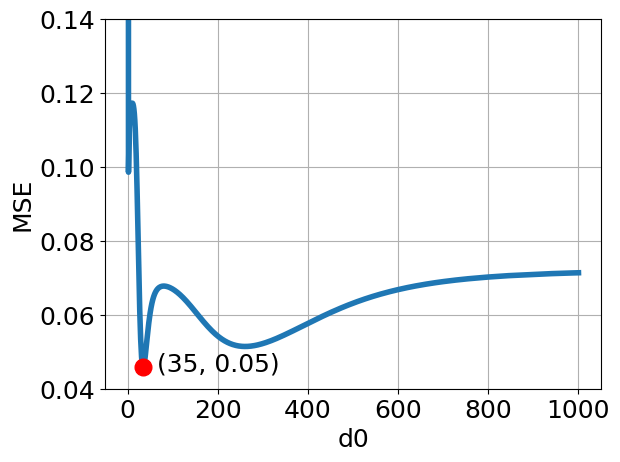

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0084169
      Initializing linear solver - done. Time (sec):  0.0084717
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0001731
      Solving linear system (col. 0) - done. Time (sec):  0.0009360
   Training - done. Time (sec):  0.0099392
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Pre

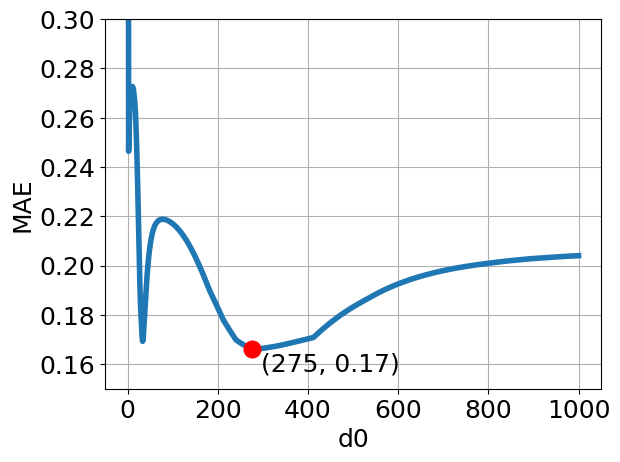

In [4]:
d0_values = np.linspace(0.0001, 1000, 1000)
#print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    mae = mean_absolute_error(Y_val, Y_pred)
    results[d0_values[i]] = mse

xmax = min(results, key=results.get)
ymax = results[xmax]
plt.ylim(0.04, 0.14)
plt.plot(results.keys(), results.values(), lw=4)
plt.plot(min(results, key=results.get), min(results.values()), 'ro', markersize=12)
plt.annotate(f'({xmax:.0f}, {ymax:.2f})', xy=(xmax, ymax), xytext=(xmax+30, ymax-0.001), fontsize=18)
plt.xlabel('d0', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

d0_values = np.linspace(0.0001, 1000, 1000)
#print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    mae = mean_absolute_error(Y_val, Y_pred)
    results[d0_values[i]] = mae

xmax = min(results, key=results.get)
ymax = results[xmax]
plt.ylim(0.15, 0.3)
plt.plot(results.keys(), results.values(), lw=4)
plt.plot(min(results, key=results.get), min(results.values()), 'ro', markersize=12)
plt.annotate(f'({xmax:.0f}, {ymax:.2f})', xy=(xmax, ymax), xytext=(xmax+20, ymax-0.009), fontsize=18)
plt.xlabel('d0', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()


In [5]:
RBF_model = RBF(d0=min(results, key=results.get))
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0001609
      Initializing linear solver - done. Time (sec):  0.0002141
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000520
      Solving linear system (col. 0) - done. Time (sec):  0.0002208
   Training - done. Time (sec):  0.0016289


In [6]:
predicted_values = RBF_model.predict_values(generating_array_scaled)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0107532
   
   Prediction time/pt. (sec) :  0.0000011
   


In [8]:
# adding the predicted values to the dataframe
generating_df['predicted_mean_force'] = predicted_values
generating_df.head()

,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs,predicted_mean_force
0,2.76,1.96,1.67,75.29,127.80,278.56,73252.4,27.026028
1,2.84,2.29,1.39,75.81,127.68,277.41,65871.1,26.439684
2,2.63,2.21,1.53,75.94,128.37,289.44,65737.1,25.755810
3,2.52,1.85,1.52,75.57,127.39,285.63,63937.5,23.598574
4,2.78,1.97,1.52,75.45,128.33,282.14,71745.5,26.836786


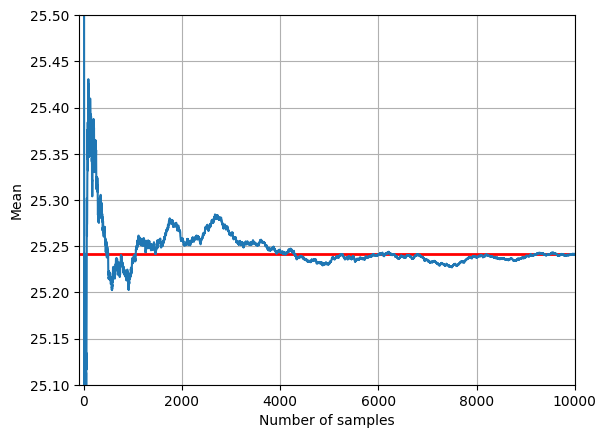

In [84]:
# Check convergence of mean
mean = np.zeros(len(generating_df))
for i in range(len(generating_df)):
    mean[i] = np.mean(generating_df['predicted_mean_force'][:i+1])

plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999]), color='r', linewidth=2)
#plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999])*1.001, color='r', linewidth=1)
#plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999])*0.999, color='r', linewidth=1)

plt.plot(mean)
plt.xlabel('Number of samples')
plt.ylabel('Mean')
plt.ylim(25.1, 25.5)
plt.xlim(-100, 10000)
plt.grid()

Text(0, 0.5, 'Frequency')

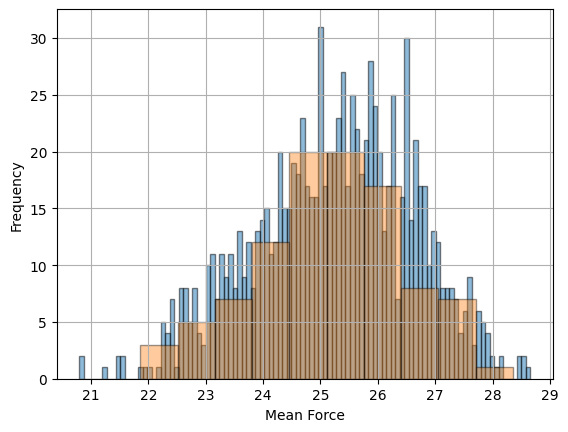

In [49]:
plt.hist(
    x=generating_df['predicted_mean_force'][:1000],
    bins=100,
    label='Predicted',
    alpha=0.5, 
    edgecolor='black',
    linewidth=1)
plt.hist(
    x=training_df['mean_force'], 
    bins=10, 
    label='Training', 
    alpha=0.4, 
    edgecolor='black', 
    linewidth=1)
plt.grid()
plt.xlabel('Mean Force')
plt.ylabel('Frequency')

<h1>Changing amount of data

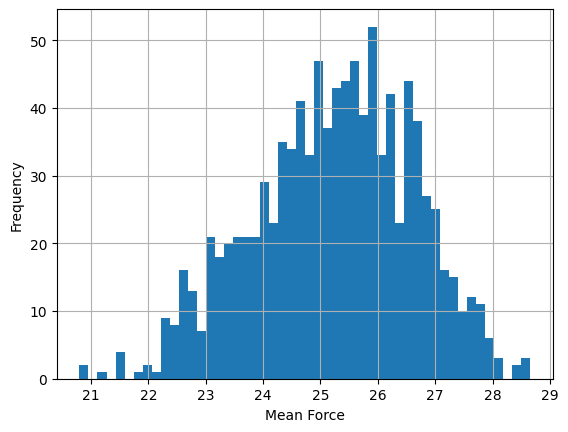

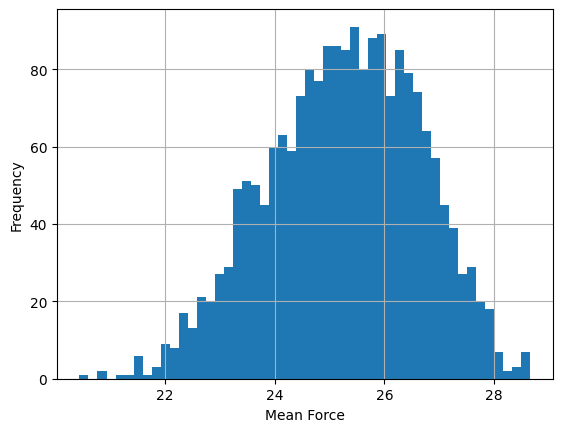

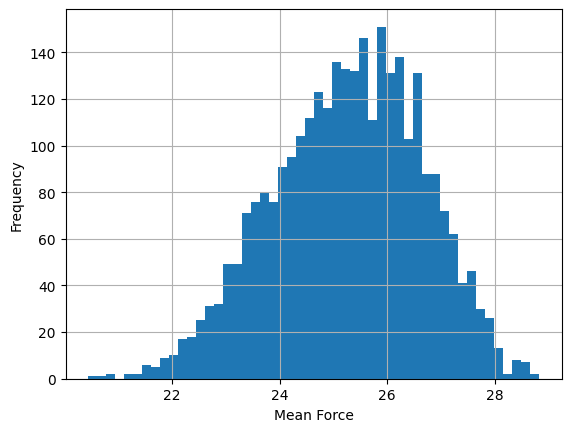

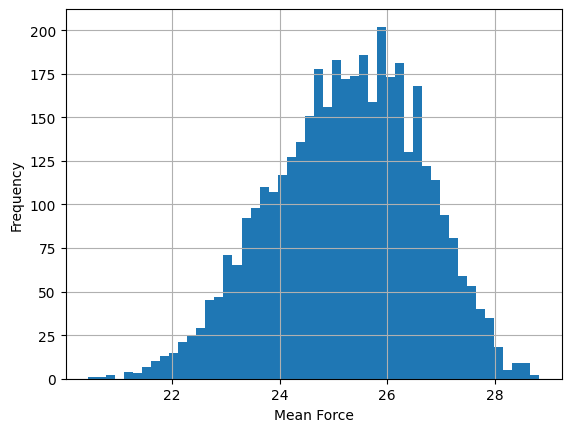

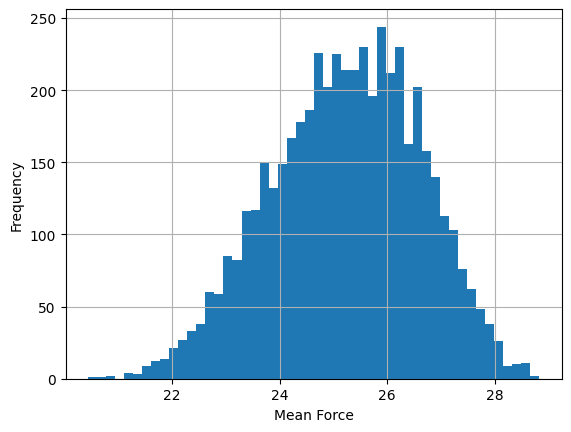

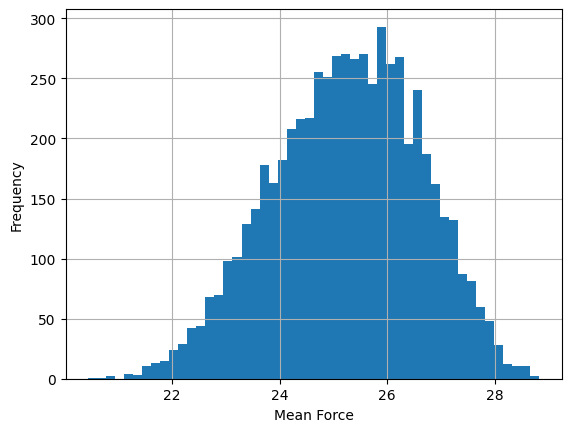

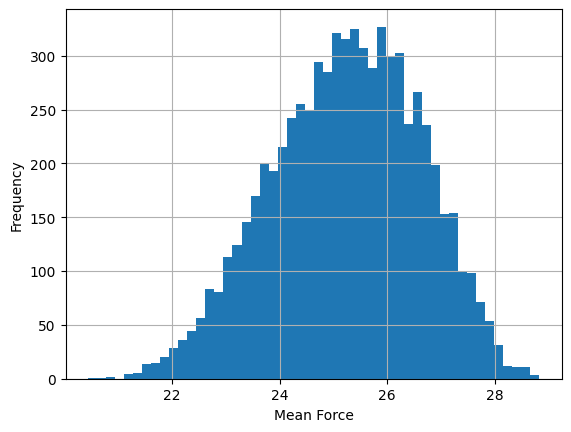

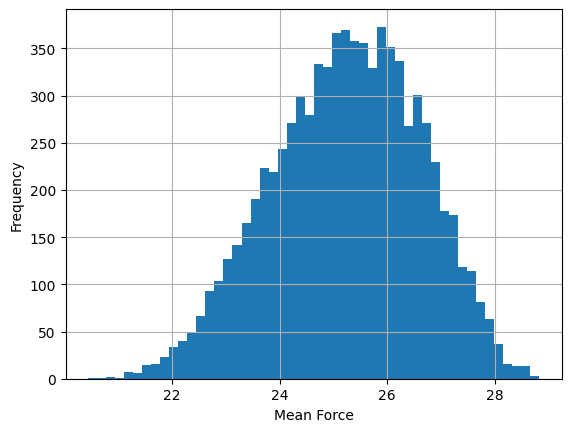

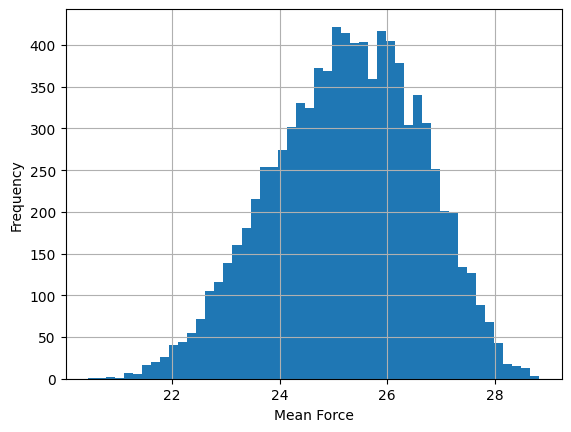

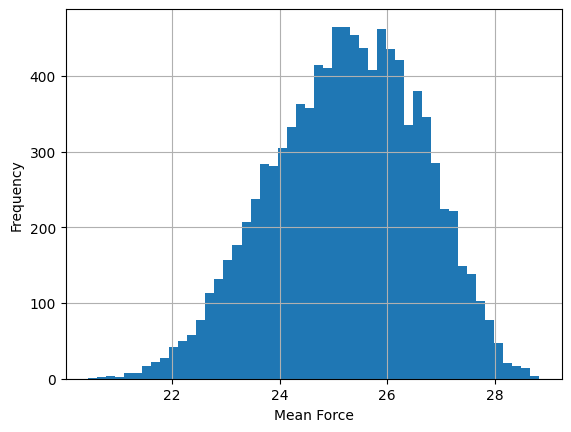

In [64]:
for i in range(10):
    plt.hist(
        x=generating_df['predicted_mean_force'][:1000*(i+1)],
        bins=50,
        label='Predicted',
    )
    plt.grid()
    plt.xlabel('Mean Force')
    plt.ylabel('Frequency')
    plt.show()

<h1>Changing number of boxes

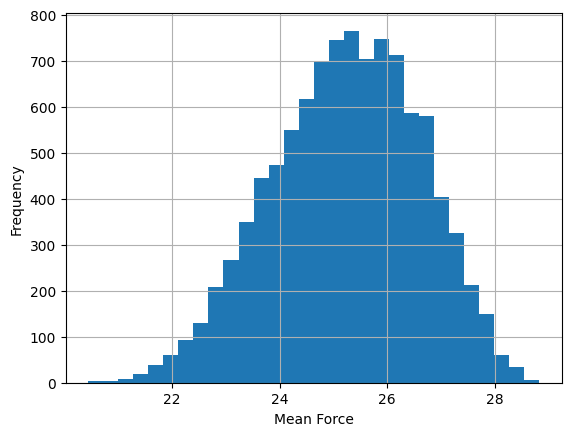

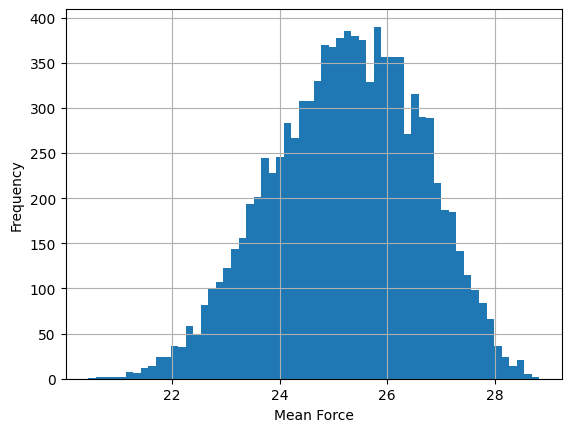

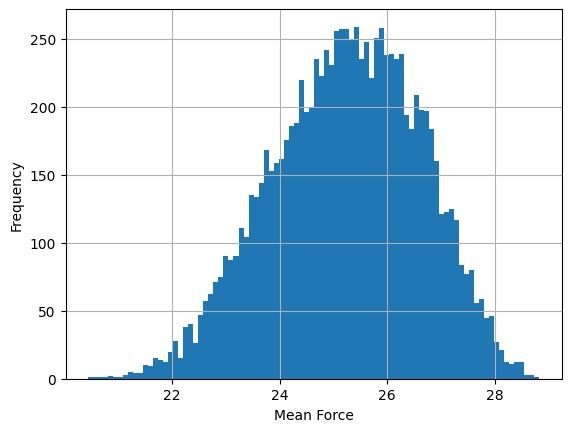

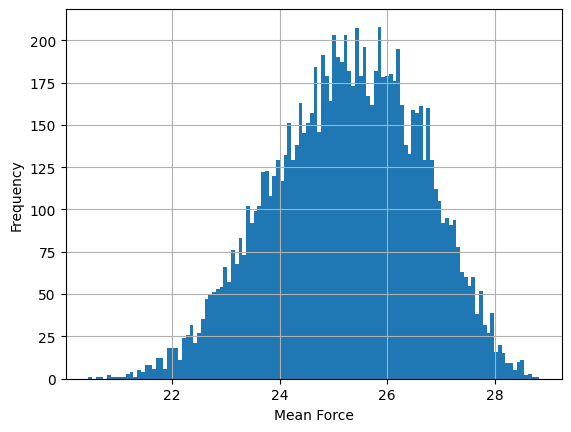

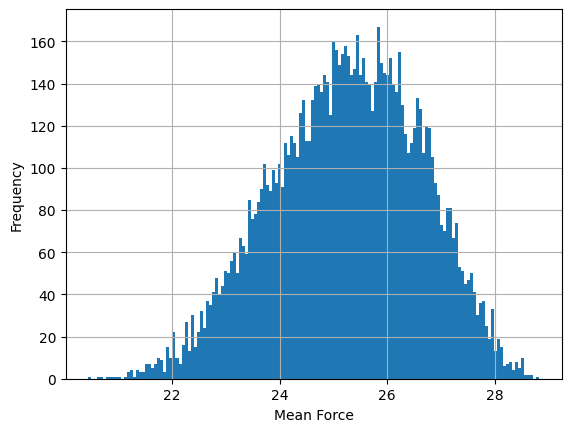

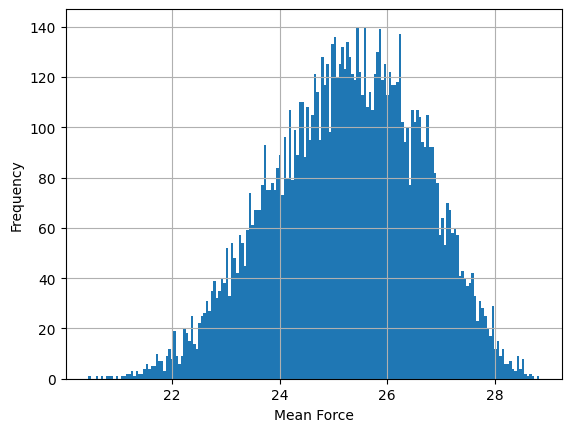

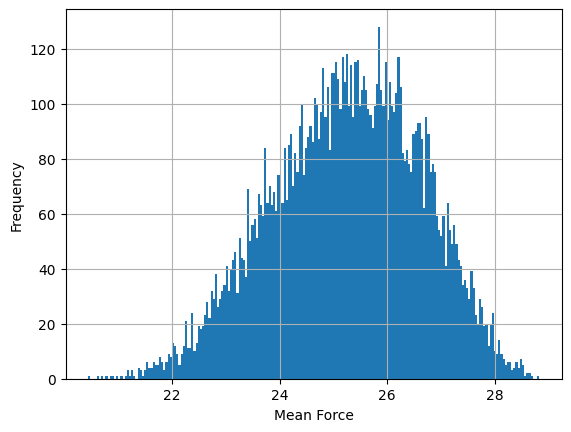

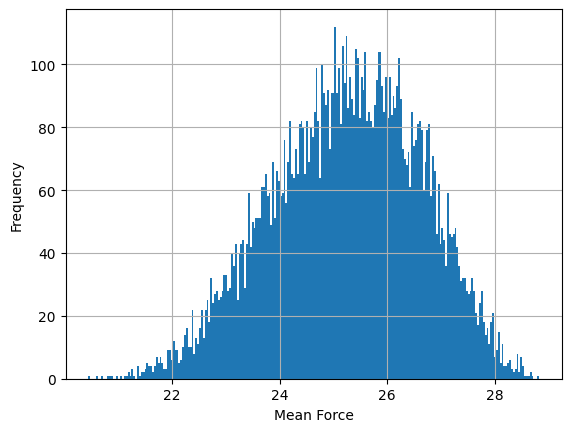

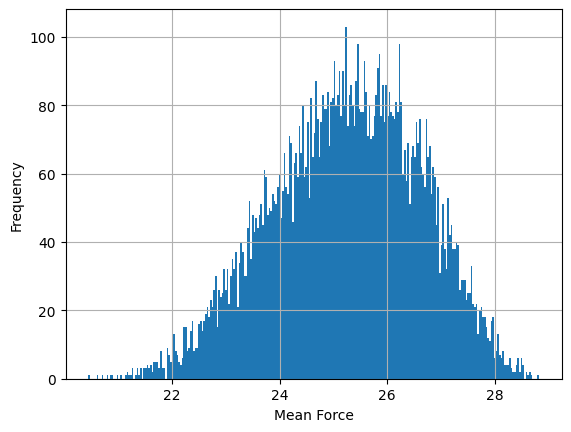

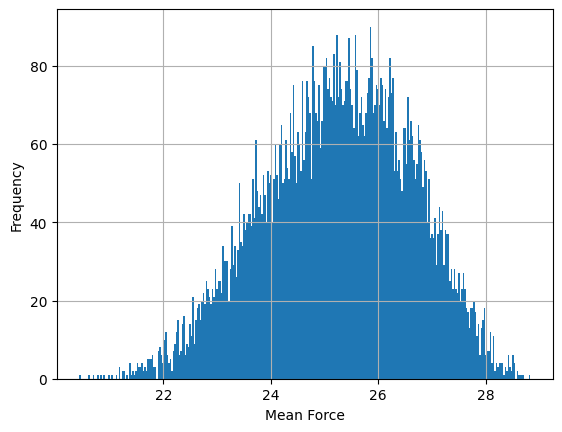

In [60]:
for i in range(10):
    plt.hist(
        x=generating_df['predicted_mean_force'],
        bins=30*(i+1),
        label='Predicted'
    )
    plt.grid()
    plt.xlabel('Mean Force')
    plt.ylabel('Frequency')
    plt.show()